In [8]:
## Import
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn import svm
from sklearn.decomposition import PCA
import statistics
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from load_data import load_data
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.pipeline import Pipeline

# Classifiers and kernels
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

#
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer, make_column_selector as selector


In [9]:
def scatterplot_distribution(Y,Y1,Y2,data,X1,X2):

    encoder = LabelEncoder()
    Y = encoder.fit_transform(Y)
    
    title1 =(f'{X1=}'.split('=')[0])
    title2  = (f'{X2=}'.split('=')[0])
    
    colour = sns.color_palette("Set2")
    color1=colour[0]
    color2=colour[1]
    colormap = np.array([color1,color2])

    fig = plt.figure(figsize=(16,4))
    ax = fig.add_subplot(131)
    ax.set_title(f"Brats, entire dataset = {len(data)}", fontsize=15)
    ax.scatter(data.iloc[:,0], data.iloc[:,1], marker='o', c=colormap[Y],
            s=45, edgecolor='k', cmap=plt.cm.Paired)

    ax = fig.add_subplot(132)
    ax.set_title(title1 + f"={len(X1)}", fontsize=15)
    ax.scatter(X1[:,0], X1[:,1], marker='o', c=colormap[Y1],
            s=45, edgecolor='k', cmap=plt.cm.Paired)

    ax = fig.add_subplot(133)
    ax.set_title(title2 + f"={len(X2)}", fontsize=15)
    ax.scatter(X2[:,0], X2[:,1], marker='o', c=colormap[Y2],
            s=45, edgecolor='k', cmap=plt.cm.Paired)   

    GBM_patch = mpatches.Patch(color=colour[0], label='GBM')
    LGG_patch = mpatches.Patch(color=colour[1], label='LGG')
    fig.legend(handles=[GBM_patch, LGG_patch],loc="center right", prop={'size': 12})
    fig.subplots_adjust(right=0.95)

    plt.show() 




In [10]:
def get_data_ready():
    data = load_data() 
    X = data
    X = X.replace(np.inf, np.nan)
    X.drop_duplicates(keep='first')
    X.columns.drop_duplicates(keep='first')
    Y = data['label']
    del X['label']
    # print(f'Shape of data = {data.shape}, X = {X.shape} Y = {Y.shape}')
    # print(f'Number of duplicated datasets = {X.duplicated().sum()}')
    # print(f'Number of duplicated features = {X.columns.duplicated().sum()}')
    # print(f'Number of infinite values = {X.isin([np.inf, -np.inf]).sum().sum()}')
    # print(f'Number of NaN values = {X.isna().sum().sum()}')
    return data, X, Y

def remove_features(X):
    acceptabele_ratio = 0.5
    train_size = len(X.index)
    removal_rate = round(train_size*acceptabele_ratio)
    X = X.dropna(axis=1, thresh=removal_rate)
    # print(f'Shape of X = {X.shape}')
    
    return X

def split_data(X,Y):
    X_train, X_test, Y_train, Y_test= train_test_split(X, Y, test_size = 0.2, random_state = 0, stratify = Y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    return X_train, X_test, Y_train, Y_test

def encode_y(Y_train, Y_test):
    encoder = LabelEncoder()
    encoder.fit(Y_train)
    Y_train = encoder.transform(Y_train)
    Y_test = encoder.transform(Y_test)

    return Y_train,Y_test

def preprocess_x(X_train,X_test):
    x_pipe = Pipeline([('imputer', KNNImputer()), ('scaler', RobustScaler()),('PCA', PCA(n_components=0.99, svd_solver= 'full'))])
    x_pipe.fit(X_train)
    X_train = x_pipe.transform(X_train)
    X_test = x_pipe.transform(X_test)

    return X_train, X_test        

Shape of data = (167, 725), X = (167, 724) Y = (167,)
Number of duplicated datasets = 0
Number of duplicated features = 0
Number of infinite values = 0
Number of NaN values = 7797
Shape of X = (167, 704)
shape of Y train = (133, 704), shape of Y train = (34, 704)
values in Y train = [0 1], values in Y test [0 1]
shape of Y train = (133,), shape of Y train = (34,)


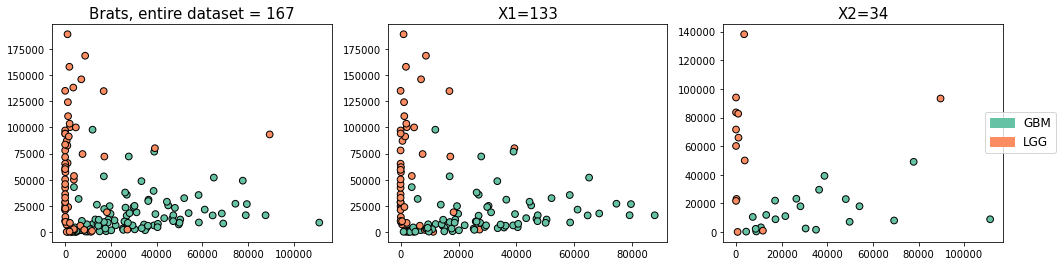

number of features after pca =2


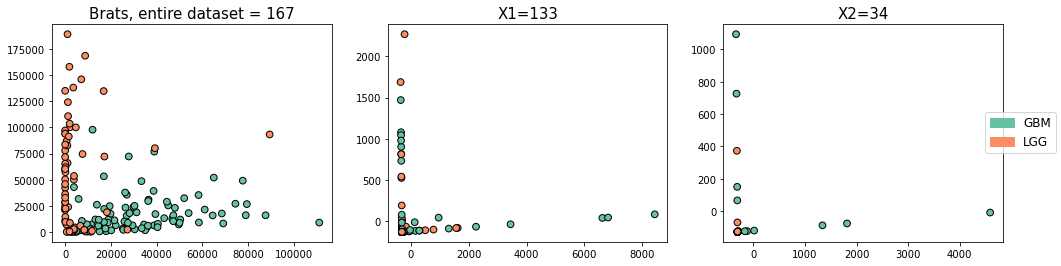

In [11]:
data,X,Y = get_data_ready()
print(f'Shape of data = {data.shape}, X = {X.shape} Y = {Y.shape}')
print(f'Number of duplicated datasets = {X.duplicated().sum()}')
print(f'Number of duplicated features = {X.columns.duplicated().sum()}')
print(f'Number of infinite values = {X.isin([np.inf, -np.inf]).sum().sum()}')
print(f'Number of NaN values = {X.isna().sum().sum()}')

X = remove_features(X)
print(f'Shape of X = {X.shape}')

X_train, X_test, Y_train, Y_test = split_data(X,Y)
print(f'shape of Y train = {(X_train.shape)}, shape of Y train = {(X_test.shape)}')

Y_train, Y_test = encode_y(Y_train, Y_test)
print(f'values in Y train = {np.unique(Y_train)}, values in Y test {np.unique(Y_test)}')
print(f'shape of Y train = {(Y_train.shape)}, shape of Y train = {(Y_test.shape)}')

scatterplot_distribution(Y,Y_train,Y_test,data,X_train,X_test)

X_train, X_test = preprocess_x(X_train, X_test)
print(f'number of features after pca ={X_train.shape[1]}')

scatterplot_distribution(Y,Y_train,Y_test,data,X_train,X_test)



In [12]:
clf_list = [KNeighborsClassifier(), DecisionTreeClassifier(), LogisticRegression(), GaussianNB(), RandomForestClassifier(), SVC(), MLPClassifier()]

parameters_list = [
        {
                    "n_neighbors": list(range(1, 10, 2)),
                    "weights": ["uniform", "distance"],
                    "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]
        },
        {
                    "criterion": ['gini', 'entropy'],
                    "min_samples_split": list(range(2,40,2)),
                    "max_features": [1,2,3,4],
                    "min_samples_leaf": list(range(1,20,2)),
        },
        {
                    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
                    'penalty' :["l1", 'l2', 'elasticnet', 'none'],
                    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        },
        {
                    "var_smoothing": list(np.logspace(0,-9, num=101))
        },
        {
                    "criterion": ['gini', 'entropy'],
                    "min_samples_split": list(range(2,40,2)),
                    "max_features": [1,2,3,4],
                    "min_samples_leaf": list(range(1,20,2)),

        },
        {
            
        },
        {
                    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                    # 'activation': ['tanh', 'relu'],
                    # 'solver': ['sgd', 'adam'],
                    # 'alpha': [0.0001, 0.05],
                    # 'learning_rate': ['constant','adaptive'],
        },

]  

In [66]:
def classifier(k):
    cv_10fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
    cv_5fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    results = pd.DataFrame()

    for train_index, validation_index, in cv_10fold.split(X_train, Y_train):

        X_train_CV = X_train[train_index]
        Y_train_CV = Y_train[train_index]

        X_validation_CV = X_train[validation_index]
        Y_validation_CV = Y_train[validation_index]

        clf = clf_list[k]
        parameters = parameters_list[k]
        randomized_search = RandomizedSearchCV(clf, parameters, cv=cv_5fold, scoring='roc_auc', n_iter = 10)
        randomized_search.fit(X_train_CV, Y_train_CV)

        # Get resulting classifier
        clf = randomized_search.best_estimator_
        parameters_results =clf.get_params()

        # Test the classifier on the train data
        probabilities = clf.predict_proba(X_train_CV)
        scores = probabilities[:, 1]

        # Get the auc
        auc = metrics.roc_auc_score(Y_train_CV, scores)
        param_name = ['auc'] + [item for item in parameters] + ['set']
        row = []
        row.append(auc)
        for item in parameters:
            row.append(parameters_results[item])
        row.append('train')
        results = results.append(pd.Series(row, index = param_name), ignore_index=True)

        # Test the classifier on the validation data
        probabilities_validation = clf.predict_proba(X_validation_CV)
        scores_validation = probabilities_validation[:, 1]

        # Get the auc
        auc_validation = metrics.roc_auc_score(Y_validation_CV, scores_validation)
        row = []
        row.append(auc_validation)
        for item in parameters:
            row.append(parameters_results[item])
        row.append('validation')
        results = results.append(pd.Series(row, index = param_name), ignore_index=True)

    #Create results dataframe and plot it
    results = pd.DataFrame(results)
    # sns.boxplot(y='auc', x='set', data=results).set_title(f'{clf_list[k]}')

    optimal_parameter = []
    parameter_keys = list(parameters.keys())

    for item in parameter_keys:
        best_item = []
        for i in list(range(0,10,2)):
            best_item.append(results[item][i])

        optimal_parameter.append(statistics.median(best_item))
        # print(f"The optimal {item}={optimal_parameter[-1]}")
    optimal_parameter = optimal_parameter
    # print(f'{clf_list[k]} done')
    
    return results, optimal_parameter    



In [268]:
# def plot_val_test_error(k,length,error):
#     fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 8), sharey='row')
#     fig.suptitle(f'{clf_list[k]}')
        
#     ax1.plot(range(1,length+1),v['auc'], label = 'Validation')
#     ax1.title.set_text(f'med val={all_val_med[k]}, med train={all_t_med[k]}')
#     ax1.plot(range(1,length+1),t['auc'], label = 'train')
#     ax2.set_title(f'median error={all_error_med[0]}', fontsize=12)
#     ax2.plot(range(1,length+1), error, label = 'error', color='r')
#     ax1.set_ylabel('auc', fontsize=12)
#     ax2.set_ylabel('error', fontsize=12)
#     ax1.legend(loc=4)
#     ax2.legend(loc=4)
#     plt.show()

# def boxplot_results(k):
#     sns.boxplot(y='auc', x='set', data=all_results[k]).set_title(f'{clf_list[k]}')
#     return all_results[k]    

In [280]:
def all_scores():
    all_results = []
    all_optimal_parameters = []
    all_t_med = []
    all_val_med = []
    all_error = []
    all_error_med = []

    for i in range(0,5):
        results, optimal_parameters = classifier(i)

        v = results[results['set']=='validation']
        t = results[results['set']=='train']
        
        v_med = round(v['auc'].median(),2)
        all_val_med.append(v_med)
        t_med = round(t['auc'].median(),2)
        all_t_med.append(t_med)

        length = len(v['auc'])

        error = []
        for l in range(0,length):
            error.append(abs(list(t['auc'])[l] - list(v['auc'])[l]))
        all_error.append(error)    
        all_error_med.append(round(np.median(error),2))    
        
        all_results.append(results)
        all_optimal_parameters.append(optimal_parameters)

   
    return all_results, all_optimal_parameters, all_t_med, all_val_med, all_error, all_error_med

In [281]:
all_results, all_optimal_parameters, all_t_med, all_val_med, all_error, all_error_med, = all_scores()

KNeighborsClassifier() done
DecisionTreeClassifier() done
LogisticRegression() done
GaussianNB() done
RandomForestClassifier() done


In [285]:
def best_model():
    best_model = np.argmax(all_val_med)
    return print(f'{clf_list[best_model]} is the best model with a median validation score of {np.max(all_val_med)}')    

In [287]:
best_model()

RandomForestClassifier() is the best model with a median validation score of 0.72


The optimal n_neighbors=5.0
The optimal weights=uniform
The optimal metric=manhattan


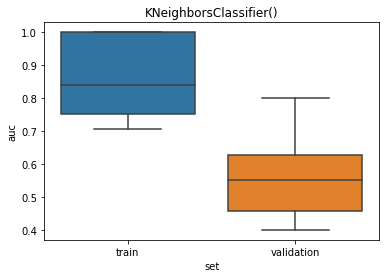

In [34]:
knn_results, knn_parameters = classifier(0)
dtree_results, dtree_parameters = classifier(1)
lr_results, lr_parameters = classifier(2)
gnb_results, gnb_parameters = classifier(3)
rf_results, rf_parameters = classifier(4)